# Part I - Accident and Emergency Department Synthetic Admission Data Analysis
## by Generoso Roberto

## Introduction

Analysis of health care data has a huge potential to improve health services and patient outcomes but practicing and creating analytical tools and processes is tricky since patient privacy needs to be preserved. The dataset that is used is the A&E Synthetic Data which created as a result of an NHS England pilot project to share more data without sacrifising the privacy of patients. The project used statistical models to that tries create datasets that retains the value of the original data but can not be used to re-identify specific individual records. 

This provides an opportunity for us to get to look and analyze the A&E data that NHS collects. For this analysis the focus is on admitted cases in just one hospital.

The columns in the dataset are the following:
* `IMD_Decile_From_LSOA` - measure of deprivation. A score of 1 indicates the entry comes from the 10% most deprived area in England
* `Age_Band` - The interval of the age of the patient
* `Sex` - Coded in 1 and 2 to represent the two sexes
* `AE_Arrive_Date` - The date the patient arrived at the A&E provider
* `AE_Arrive_HourOfDay` - The interval of what time the patient arrived at the A&E
* `AE_Time_Mins` - Total number of minutes the patient stayed in the A&E
* `AE_HRG` - Code for the health reference group
* `AE_Num_Diagnoses` - Number of diagnoses the patient have in the A&E
* `AE_Num_Investigations` - Number of investigations done to the patient
* `AE_Num_Treatments` - Number of treatments done to the patient
* `AE_Arrival_Mode` - Code for the mode by which  patient arrived
* `Provider_Patient_Distance_Miles` - Distance from the patient place of origin to the provider in miles
* `Admission_Method` - Code for the method how the patient was admitted
* `ICD10_Chapter_Code` - International classification of disease chapter code
* `Treatment_Function_Code` - The treatment function under which the patient is treated.
* `Length_Of_Stay_Days` - The number of days the patient was admitted

## Preliminary Data Wrangling

In [41]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [42]:
#Load the dataset
aedata_df_original=pd.read_csv('AnE_Synthetic_Data_Provider_Admission.csv')
aedata_df = aedata_df_original

In [43]:
# High-level overview of data shape and composition
print(aedata_df.shape)
print(aedata_df.info())
print(aedata_df.head(10))
columns = aedata_df.columns
for column in columns:
    print(f'{column}: {aedata_df[column].unique()}')

(326444, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326444 entries, 0 to 326443
Data columns (total 16 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   IMD_Decile_From_LSOA             326444 non-null  int64  
 1   Age_Band                         326444 non-null  object 
 2   Sex                              326444 non-null  int64  
 3   AE_Arrive_Date                   326444 non-null  object 
 4   AE_Arrive_HourOfDay              326444 non-null  object 
 5   AE_Time_Mins                     326444 non-null  float64
 6   AE_HRG                           326372 non-null  object 
 7   AE_Num_Diagnoses                 326444 non-null  int64  
 8   AE_Num_Investigations            326444 non-null  int64  
 9   AE_Num_Treatments                326444 non-null  int64  
 10  AE_Arrival_Mode                  326444 non-null  int64  
 11  Provider_Patient_Distance_Miles  326444 non-null  fl

1. `AE_Arrive_Date` is an object and should be made into a datetime and extract the year, month and weekday
2. The following columns are categorical types
    * `Sex`
    * `AE_Arrival_Mode`
    * `Admission_Method`
    * `ICD10_Chapter_Code`
    * `Treatment_Function_Code`
    * `AE_Arrive_HourOfDay`
2. The following columns are ordered categorical types
    * `IMD_Decile_From_LSOA`
    * `Age_Band`
    * `AE_Arrive_HourOfDay`
    * `AE_HRG`
3. The following columns have null values:
    * `AE_HRG`
    * `ICD10_Chapter_Code`
    * `Treatment_Function_Code`
    * `Length_Of_Stay_Days`

In [44]:
# 1. Convert 'AE_Arrive_Date' to datetime
aedata_df['AE_Arrive_Date']=pd.to_datetime(aedata_df['AE_Arrive_Date'])
# Check the dtype of 'AE_Arrive_Date'
print(f"The datatype of the column AE_Arrive_Date is {aedata_df['AE_Arrive_Date'].dtype}")
# Extract year, month and weekday
aedata_df['Year'] = aedata_df['AE_Arrive_Date'].dt.strftime('%Y')
aedata_df['Month'] = aedata_df['AE_Arrive_Date'].dt.strftime('%b')
aedata_df['Weekday'] = aedata_df['AE_Arrive_Date'].dt.strftime('%a')
# Check the Year_Month column
aedata_df[['Year','Month','Weekday']]

The datatype of the column AE_Arrive_Date is datetime64[ns]


,Year,Month,Weekday
0,2015,May,Thu
1,2017,Sep,Sat
2,2016,Sep,Wed
3,2014,Mar,Sun
4,2017,Nov,Sat
...,...,...,...
326439,2017,Nov,Thu
326440,2017,May,Fri
326441,2015,Jul,Sun
326442,2016,Aug,Fri


In [45]:
# 2. Convert columns into categorical type
# Create a function that converts columns into category
def covert_to_categorical(df, column_list):
    for column in column_list:
        df[column] = df[column].astype('category')
# Create a list of columns to be made into category
categorical_columns = [\
    'Sex',
    'AE_Arrival_Mode',
    'Admission_Method',
    'ICD10_Chapter_Code',
    'Treatment_Function_Code',
    'AE_Arrive_HourOfDay',
    'Year',
    'Month',
    'Weekday'
    ]
# Convert columns into category
covert_to_categorical(aedata_df,categorical_columns)
# Check the dtypes
aedata_df[categorical_columns].dtypes

Sex                        category
AE_Arrival_Mode            category
Admission_Method           category
ICD10_Chapter_Code         category
Treatment_Function_Code    category
AE_Arrive_HourOfDay        category
Year                       category
Month                      category
Weekday                    category
dtype: object

In [46]:
# 3. Convert column to categorical types
# Create a list of columns to be made into ordered categorical data
ordinal_columns = [\
    'IMD_Decile_From_LSOA',
    'Age_Band',
    'AE_Arrive_HourOfDay',
    'AE_HRG',
    'Year',
    'Month',
    'Weekday'
    ]
# Check the different values of the columns to be changed into ordered category
# Create a function to print the unique values
def check_unique_values(df, column_list):
    for column in column_list:
        print(f'{column} : {df[column].unique()}')
# Check the unique values of the identified ordered categorical types
check_unique_values(aedata_df, ordinal_columns)

IMD_Decile_From_LSOA : [ 2  3  1  4  8  9  5  7  6 10]
Age_Band : ['1-17' '65-84' '85+' '18-24' '45-64' '25-44']
AE_Arrive_HourOfDay : ['17-20', '13-16', '05-08', '21-24', '09-12', '01-04']
Categories (6, object): ['01-04', '05-08', '09-12', '13-16', '17-20', '21-24']
AE_HRG : ['Nothing' 'Low' 'High' 'Medium' nan]
Year : ['2015', '2017', '2016', '2014', '2018']
Categories (5, object): ['2014', '2015', '2016', '2017', '2018']
Month : ['May', 'Sep', 'Mar', 'Nov', 'Jan', ..., 'Jun', 'Aug', 'Oct', 'Apr', 'Dec']
Length: 12
Categories (12, object): ['Apr', 'Aug', 'Dec', 'Feb', ..., 'May', 'Nov', 'Oct', 'Sep']
Weekday : ['Thu', 'Sat', 'Wed', 'Sun', 'Fri', 'Mon', 'Tue']
Categories (7, object): ['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed']


In [47]:
# Convert the ordered_categorical_columns into category type
covert_to_categorical(aedata_df,ordinal_columns)
# Create a dictionary that shows the order of the values
ordinal_columns_dict={\
    'IMD_Decile_From_LSOA': [1,2,3,4,5,6,7,8,9,10],
    'Age_Band':['1-17','18-24','25-44', '45-64', '65-84', '85+'],
    'AE_HRG':['Nothing','Low','Medium','High'],
    'Year':['2014', '2015', '2016', '2017', '2018'],
    'Month':['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug',
    'Sep','Oct','Nov','Dec'],
    'Weekday':['Mon','Tue','Wed','Thu','Fri','Sat','Sun'],
    'AE_Arrive_HourOfDay':['01-04','05-08','09-12','13-16','17-20','21-24']
    }
# Create a function that uses a dictionary to order the ordinal columns
def order_categorical(df, column_dict):
    for column in column_dict:
        df[column] = df[column].cat.set_categories(column_dict[column], ordered=True)
# Order the ordinal categorical data
order_categorical(aedata_df,ordinal_columns_dict)

In [48]:
# Check the ordinal columns
for column in ordinal_columns:
    print(aedata_df[column])

0         2
1         2
2         3
3         1
4         2
         ..
326439    1
326440    3
326441    3
326442    2
326443    2
Name: IMD_Decile_From_LSOA, Length: 326444, dtype: category
Categories (10, int64): [1 < 2 < 3 < 4 ... 7 < 8 < 9 < 10]
0          1-17
1         65-84
2          1-17
3           85+
4          1-17
          ...  
326439     1-17
326440    65-84
326441    25-44
326442    45-64
326443    65-84
Name: Age_Band, Length: 326444, dtype: category
Categories (6, object): ['1-17' < '18-24' < '25-44' < '45-64' < '65-84' < '85+']
0         17-20
1         13-16
2         17-20
3         05-08
4         13-16
          ...  
326439    21-24
326440    21-24
326441    01-04
326442    17-20
326443    13-16
Name: AE_Arrive_HourOfDay, Length: 326444, dtype: category
Categories (6, object): ['01-04' < '05-08' < '09-12' < '13-16' < '17-20' < '21-24']
0         Nothing
1             Low
2             Low
3             Low
4             Low
           ...   
326439     Medium

In [49]:
# 4. Check the rows that have null values
print(aedata_df[aedata_df.isna().any(axis=1)])

       IMD_Decile_From_LSOA Age_Band Sex AE_Arrive_Date AE_Arrive_HourOfDay  \
42                        5    65-84   1     2017-01-05               05-08   
90                        3    65-84   2     2018-01-09               13-16   
190                       1     1-17   1     2017-03-28               05-08   
231                       2     1-17   2     2016-07-05               09-12   
289                       1     1-17   1     2015-08-26               09-12   
...                     ...      ...  ..            ...                 ...   
326188                    2    25-44   2     2016-01-30               13-16   
326324                    6    65-84   2     2016-09-03               09-12   
326343                    5    45-64   2     2018-03-18               09-12   
326358                    4    25-44   1     2015-04-12               13-16   
326364                    2    65-84   2     2016-03-24               21-24   

        AE_Time_Mins   AE_HRG  AE_Num_Diagnoses  AE

What percentage of the rows in the dataset have missing values?

In [50]:
# Compute the percentage of rows that have missing values
print(f"{round(len(aedata_df[aedata_df.isna().any(axis=1)])/len(aedata_df)*100,2)} % of rows have a null value.")

1.44 % of rows have a null value.


Theoretically, these null values would need to be farther assessed. Weather the null values are missing in a systematic way or purely random, weather the missing values could be imputed etc. But in the interest of time, I decided to remove the rows that have null values.

In [51]:
# Remove rows that have null values
aedata_df.dropna(axis=0,inplace=True)
# Check again the info of the working dataframe
aedata_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 321748 entries, 0 to 326443
Data columns (total 19 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   IMD_Decile_From_LSOA             321748 non-null  category      
 1   Age_Band                         321748 non-null  category      
 2   Sex                              321748 non-null  category      
 3   AE_Arrive_Date                   321748 non-null  datetime64[ns]
 4   AE_Arrive_HourOfDay              321748 non-null  category      
 5   AE_Time_Mins                     321748 non-null  float64       
 6   AE_HRG                           321748 non-null  category      
 7   AE_Num_Diagnoses                 321748 non-null  int64         
 8   AE_Num_Investigations            321748 non-null  int64         
 9   AE_Num_Treatments                321748 non-null  int64         
 10  AE_Arrival_Mode                  321748 non-

In [52]:
# descriptive statistics for numeric variables
print(aedata_df.describe().T)

                                    count        mean         std  min    25%  \
AE_Time_Mins                     321748.0  286.239510  172.121087  0.0  200.0   
AE_Num_Diagnoses                 321748.0    0.341323    0.696037  0.0    0.0   
AE_Num_Investigations            321748.0    6.778420    3.480049  0.0    4.0   
AE_Num_Treatments                321748.0    3.599043    2.351271  0.0    2.0   
Provider_Patient_Distance_Miles  321748.0    4.751557   13.997934  0.0    1.0   
Length_Of_Stay_Days              321748.0    4.329659    9.588165  0.0    0.0   

                                   50%    75%     max  
AE_Time_Mins                     240.0  340.0  1440.0  
AE_Num_Diagnoses                   0.0    1.0    10.0  
AE_Num_Investigations              8.0   10.0    10.0  
AE_Num_Treatments                  3.0    5.0    10.0  
Provider_Patient_Distance_Miles    2.0    4.0   200.0  
Length_Of_Stay_Days                1.0    4.0   180.0  


In [53]:
# descriptive statistics for categorical variables
print(aedata_df[[\
    'IMD_Decile_From_LSOA',
    'Age_Band',
    'Sex',
    'AE_Arrive_HourOfDay',
    'AE_HRG',
    'AE_Arrival_Mode',
    'Admission_Method',
    'ICD10_Chapter_Code',
    'Treatment_Function_Code',
    'Year',
    'Month',
    'Weekday'
    ]].describe().T)

                          count unique    top    freq
IMD_Decile_From_LSOA     321748     10      2   95761
Age_Band                 321748      6  65-84   76271
Sex                      321748      2      2  170867
AE_Arrive_HourOfDay      321748      6  13-16   74756
AE_HRG                   321748      4    Low  148553
AE_Arrival_Mode          321748      3      2  164940
Admission_Method         321748      9     21  309283
ICD10_Chapter_Code       321748      7  Other   91366
Treatment_Function_Code  321748      5    180  102532
Year                     321748      5   2016   88901
Month                    321748     12    Mar   29072
Weekday                  321748      7    Sat   51411


### What is the structure of your dataset?

> There are 321,749 A&E patient consult in the working dataset with 17 features. Four are date or period data, 6 are numeric variables, 5 categorical variables and 3 ordinal variables.
> For the ordinal variables the following are values arranged smallest to largest:
> * `IMD_Decile_From_LSOA`: 1,2,3,4,5,6,7,8,9,10
> * 'Age_Band':['1-17','18-24','25-44', '45-64', '65-84', '85+']
> * `AE_HRG`: Nothing, Low, Medium, High

### What is/are the main feature(s) of interest in your dataset?

> There are two main features that I am interested in. I want to figure out what are the features that could help in predicting the amount of time spent in the A&E (`AE_Time_Mins`) and how many days spent admitted (`Length_Of_Stay_Days`).

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?
> I could categorize the features of the dataset into the following:
> 1. A&E activities:
> * `AE_Num_Diagnoses`
> * `AE_Num_Investigations`
> * `AE_Num_Treatments`
> 2. Sociodemographic factors:
> * `IMD_Decile_From_LSOA`
> * `Age_Band`
> * `Sex`
> * `Provider_Patient_Distance_Miles`
> 3. Temporal factors:
> * `Year`
> * `Month`
> * `Weekday`
> * `AE_Arrive_HourOfDay`
> 4. Transfer Method:
> * `AE_Arrival_Mode`
> * `Admission_Method`
> 5. Disease and Treatment Factors
> * `AE_HRG`
> * `ICD10_Chapter_Code`
> * `Treatment_Function_Code`

> For the amount of time spent in the A&E, I expect that A&E activities and temporal factors could contribute the most but other variables could also contribute.
> For the days spend admitted, I expect the disease and treatment factors would be factor most as there are clinical practice guidelines that recommends how long a patient should stay admitted depending on their diagnoses but sociodemographic factors could possibly complicate things such delays in discharge that could be due to unsafe environment for post admission care.

## Visualization Functions
This section will show all the functions that I created for this analysis.

In [54]:
aedata_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 321748 entries, 0 to 326443
Data columns (total 19 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   IMD_Decile_From_LSOA             321748 non-null  category      
 1   Age_Band                         321748 non-null  category      
 2   Sex                              321748 non-null  category      
 3   AE_Arrive_Date                   321748 non-null  datetime64[ns]
 4   AE_Arrive_HourOfDay              321748 non-null  category      
 5   AE_Time_Mins                     321748 non-null  float64       
 6   AE_HRG                           321748 non-null  category      
 7   AE_Num_Diagnoses                 321748 non-null  int64         
 8   AE_Num_Investigations            321748 non-null  int64         
 9   AE_Num_Treatments                321748 non-null  int64         
 10  AE_Arrival_Mode                  321748 non-

In [55]:
def rename_variable(x):
    new_name = {'IMD_Decile_From_LSOA':'Measure of Deprivation (decile)',
    'Age_Band':'Age',
    'Sex':'Sex',
    'AE_Arrive_HourOfDay':'Hour of Arrival in A&E',
    'AE_Time_Mins': 'Time Spent in the A&E(min)',
    'AE_HRG':'Healthcare Resource Grouping',
    'AE_Num_Diagnoses': 'Number of Diagnoses at the A&E',
    'AE_Num_Investigations': 'Number of Investigations at the A&E',
    'AE_Num_Treatments': 'Number of Treatments at the A&E',
    'AE_Arrival_Mode':'Mode of Transpo to A&E',
    'Provider_Patient_Distance_Miles': 'Provider to Patient Distance (miles)',
    'Admission_Method': 'Admission Method',
    'ICD10_Chapter_Code':'ICD10 Chapter',
    'Treatment_Function_Code': 'Treatment Function',
    'Length_Of_Stay_Days': 'Time Spent Admitted(days)',
    'Year':'Year',
    'Month':'Month',
    'Weekday':'Day of the Week'
    }
    return new_name[x]

In [56]:
# function that checks if a variable is ordinal
def check_order(x):
    order=['IMD_Decile_From_LSOA','Age_Band','AE_HRG', 'AE_Arrive_HourOfDay',
    'Year', 'Month','Weekday']
    return x not in order

In [57]:
# Create a function to create a count plot
def create_countplot(data, x, title, counter=0, order=True):
    # if for only one graph
    if counter==0:
        plt.figure(figsize=(16,8))
        # if statement for order or not
        if order==True:
            ax=sns.countplot(data=data, x=x, order=data[x].value_counts().index, color='cyan')
        else:
            ax=sns.countplot(data=data, x=x, color='cyan')
        # annotate the percentage
        for c in ax.containers:
            # calculate percentage for labels
            labels=[f'{h/data[x].count()*100:0.1f}%' if (h:=v.get_height())>0 else '' for v in c]
            ax.bar_label(c, labels=labels, label_type='edge')
        ax.set(xlabel=title)
        ax.set(title=f'Distribution by {title}')
    else:
        # if statement for order or not
        if order==True:
            sns.countplot(data=data, x=x, order=data[x].value_counts().index, color='cyan',ax=counter)
        else:
            sns.countplot(data=data, x=x, color='cyan', ax=counter)
        # annotate the percentage
        for c in counter.containers:
            # calculate percentage for labels
            labels=[f'{h/data[x].count()*100:0.1f}%' if (h:=v.get_height())>0 else '' for v in c]
            counter.bar_label(c, labels=labels, label_type='edge')
        counter.set(xlabel=title)
        counter.set(title=f'Distribution by {title}')


In [58]:
# Create a function that creates histograms
def create_histogram(data, x, title, counter=0):
    # if for only one graph
    if counter==0:
        plt.figure(figsize=(16,8))
        sns.histplot(data=data, x=x, color='cyan')
        plt.xlabel(title)
        plt.title(f'Histogram of the {title}')
    else:
        sns.histplot(data=data, x=x, ax=counter, color='cyan')
        counter.set(xlabel=title)
        counter.set(title=f'Histogram of {title}')

In [59]:
# Create a function that graphs a histogram of the log of a variable
def create_his_log(data, x, title):
    data_copy = data
    data_copy['log_var']=np.log10(data[x])
    plt.figure(figsize=(16,8))
    sns.histplot(data=data, x='log_var', color='cyan')
    plt.xlabel(title)
    plt.title(f'Histogram of the {title}')

In [60]:
def univariate_multiplot(data,list_of_x=[], order=True):
    counter=0
    fig,ax=plt.subplots(nrows=len(list_of_x), figsize=[16,8*len(list_of_x)])
    for x in list_of_x:
        title = rename_variable(x)
        order = check_order(x)
        if data[x].dtype=='category':
            create_countplot(data,x,title,ax[counter],order)
        else:
            create_histogram(data,x,title,ax[counter])
        counter+=1
        

## Univariate Exploration

> In this section, investigate distributions of individual variables. If
you see unusual points or outliers, take a deeper look to clean things up
and prepare yourself to look at relationships between variables.


> **Rubric Tip**: The project (Parts I alone) should have at least 15 visualizations distributed over univariate, bivariate, and multivariate plots to explore many relationships in the data set.  Use reasoning to justify the flow of the exploration.



>**Rubric Tip**: Use the "Question-Visualization-Observations" framework  throughout the exploration. This framework involves **asking a question from the data, creating a visualization to find answers, and then recording observations after each visualisation.** 


### Dependent Variable

What are the distribution of the main variables?

#### Amount of time at the A&E

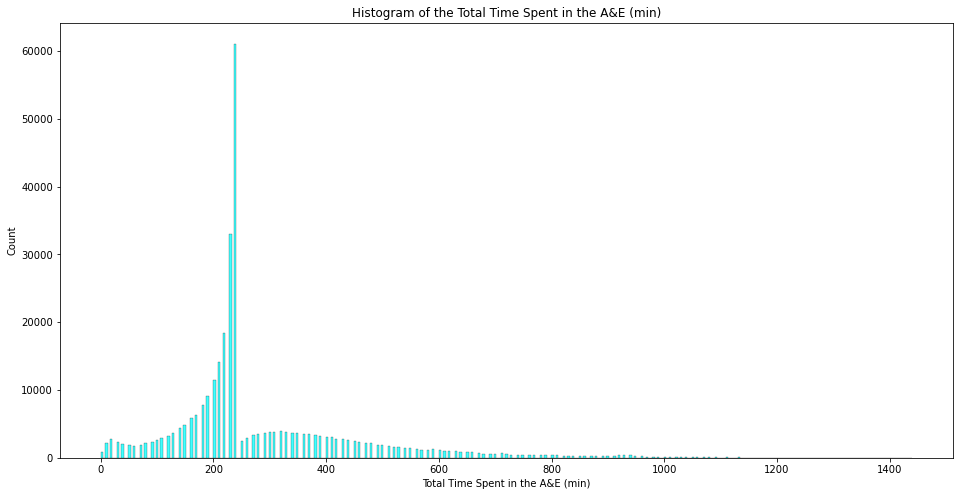

In [61]:
# plot the histogram of the amount of time at the A&E
create_histogram(aedata_df,'AE_Time_Mins', 'Total Time Spent in the A&E (min)')

The total time spent by admitted patient in the A&E initially initially peaked at around between 0-50min then reach the highest point at around 200-250min then a small peak at around 300-400min.

Since there is a long tail in the distribution, what does the ditribution look like in log scale?

/home/biogear13/miniconda3/envs/minimal_ds/lib/python3.10/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


([<matplotlib.axis.XTick at 0x7f2bf6d57100>,
 [Text(0.0, 0, '0'),
  Text(1.0, 0, '10'),
  Text(1.5, 0, '31.63'),
  Text(2.0, 0, '100'),
  Text(2.5, 0, '316.23'),
  Text(3.0, 0, '1k')])

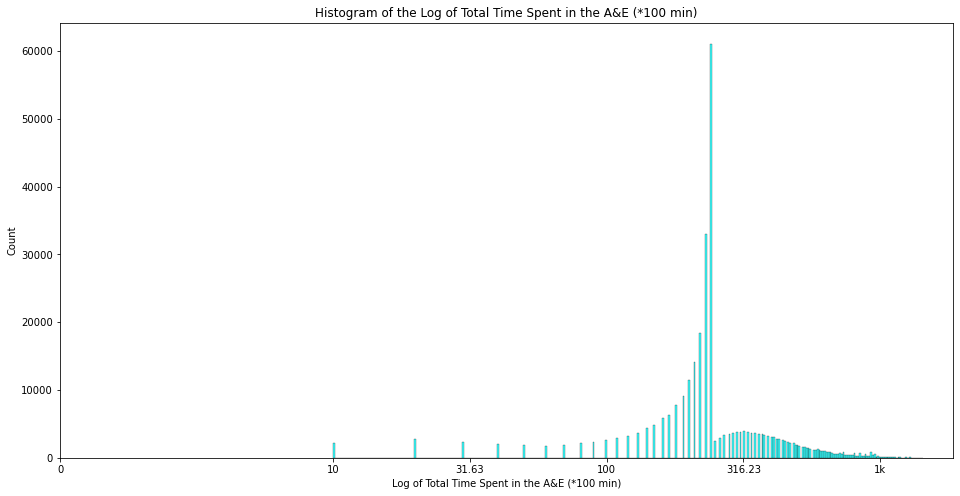

In [62]:
# Plot the histogram of the log of the value
create_his_log(aedata_df, 'AE_Time_Mins', 'Log of Total Time Spent in the A&E (*100 min)')
# Change the xticks to be more understandable
plt.xticks([0,1.0,1.5,2.0,2.5,3.0], [0, 10, 31.63, 100, 316.23, '1k'])

In the graph we see that the number of minutes, there are two peaks. One is between 100 to 316 min followed by sharp decline then another peak albeight at a far lesser magnitude at 318.23min.

### Number of Days admitted

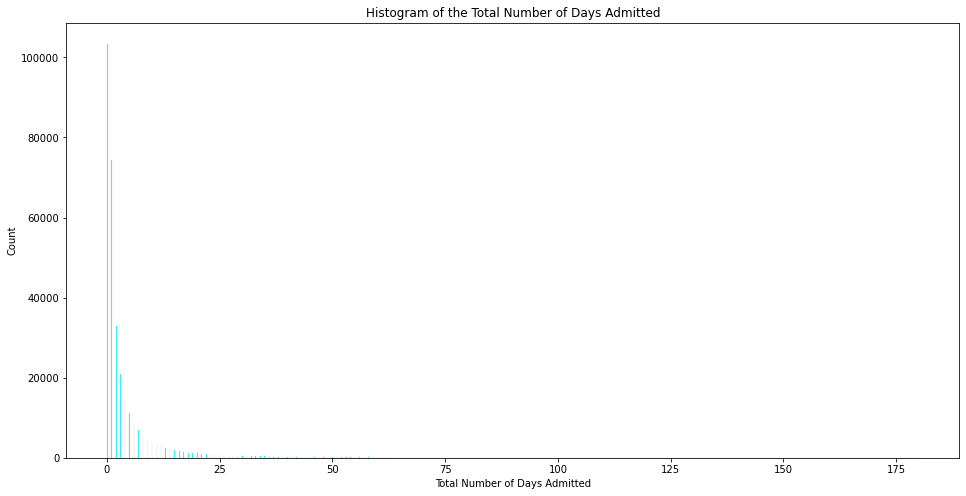

In [63]:
# plot the histogram of the number of days in the A&E
create_histogram(aedata_df,'Length_Of_Stay_Days', 'Total Number of Days Admitted')

/home/biogear13/miniconda3/envs/minimal_ds/lib/python3.10/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


([<matplotlib.axis.XTick at 0x7f2bf664c700>,
 [Text(0.0, 0, '0'),
  Text(0.5, 0, '3.16'),
  Text(1.0, 0, '10'),
  Text(1.5, 0, '31.63'),
  Text(2.0, 0, '100')])

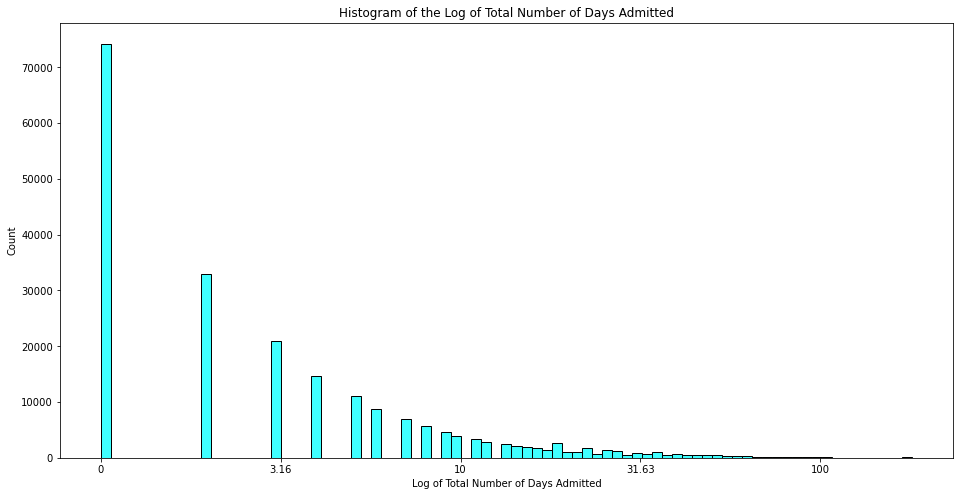

In [64]:
# There is a long tail in the distribution so I will look into the log scale
create_his_log(aedata_df, 'Length_Of_Stay_Days', 'Log of Total Number of Days Admitted')
# Change the xticks to be more understandable
plt.xticks([0,0.5,1.0,1.5,2.0], [0, 3.16, 10, 31.63, 100])

Total number of days admitted has a long-tailed distribution and when ploted in a logarithmic scale we could see that the highest is at less than 3 days.

### A&E Activities

I look at the number of diagnoses, investigations and treatments at the A&E

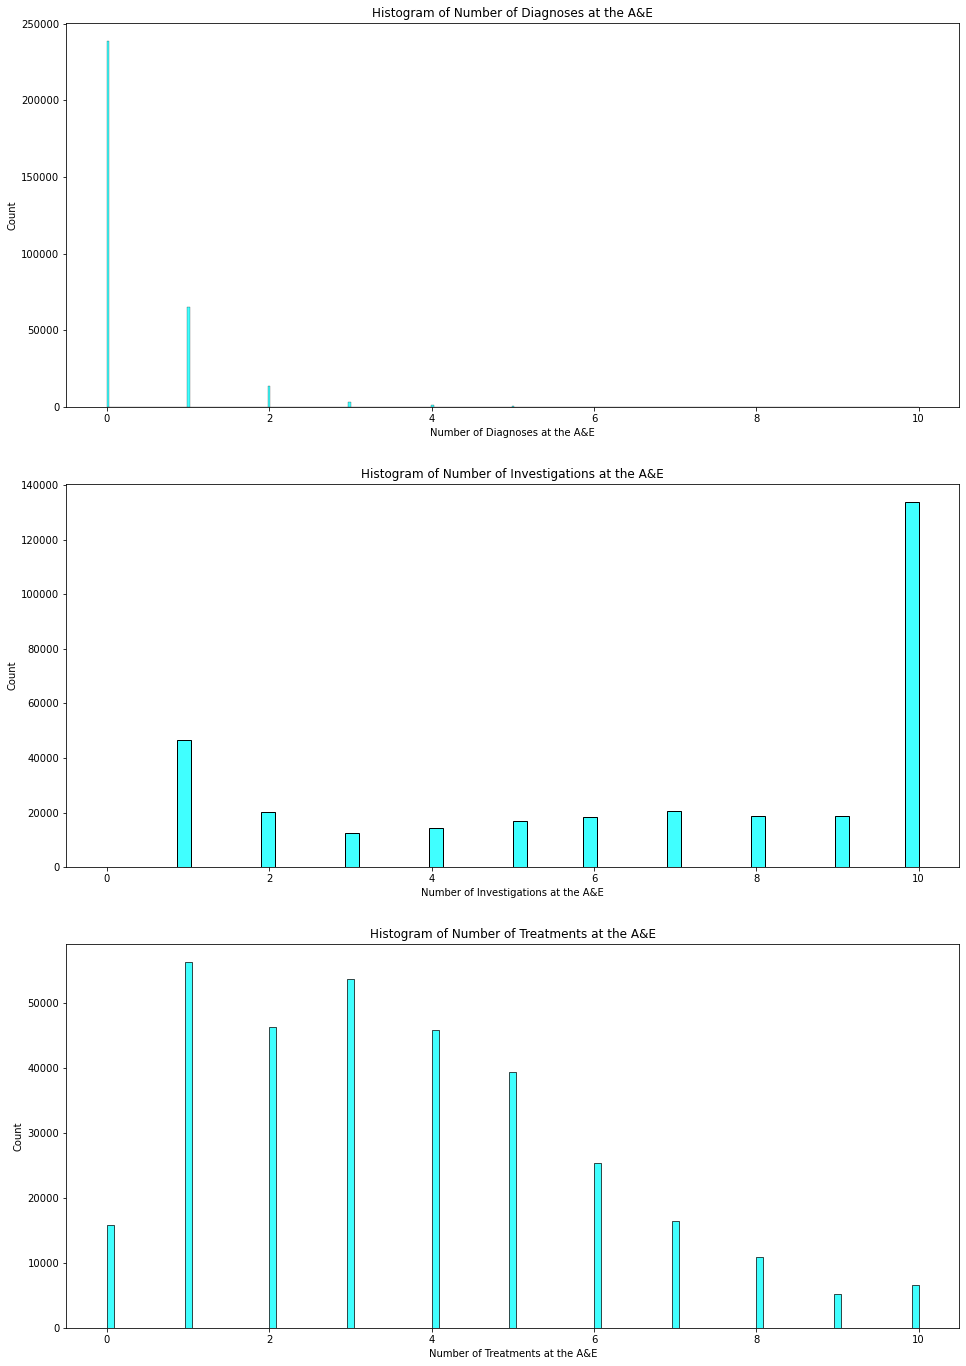

In [65]:
# Graph the three variables
univariate_multiplot(aedata_df,['AE_Num_Diagnoses','AE_Num_Investigations','AE_Num_Treatments'])

* The vast majority have zero diagnoses at the A&E
* Distribution of the number of investigations seems to be bimodal. The first peak is at one investigation done and the next and the mojority is at 10 investigations done
* The distribution looks more like a normal ditribution but the highest counts is seen at 1 and 3 treatments done.

### Sociodemographic factors

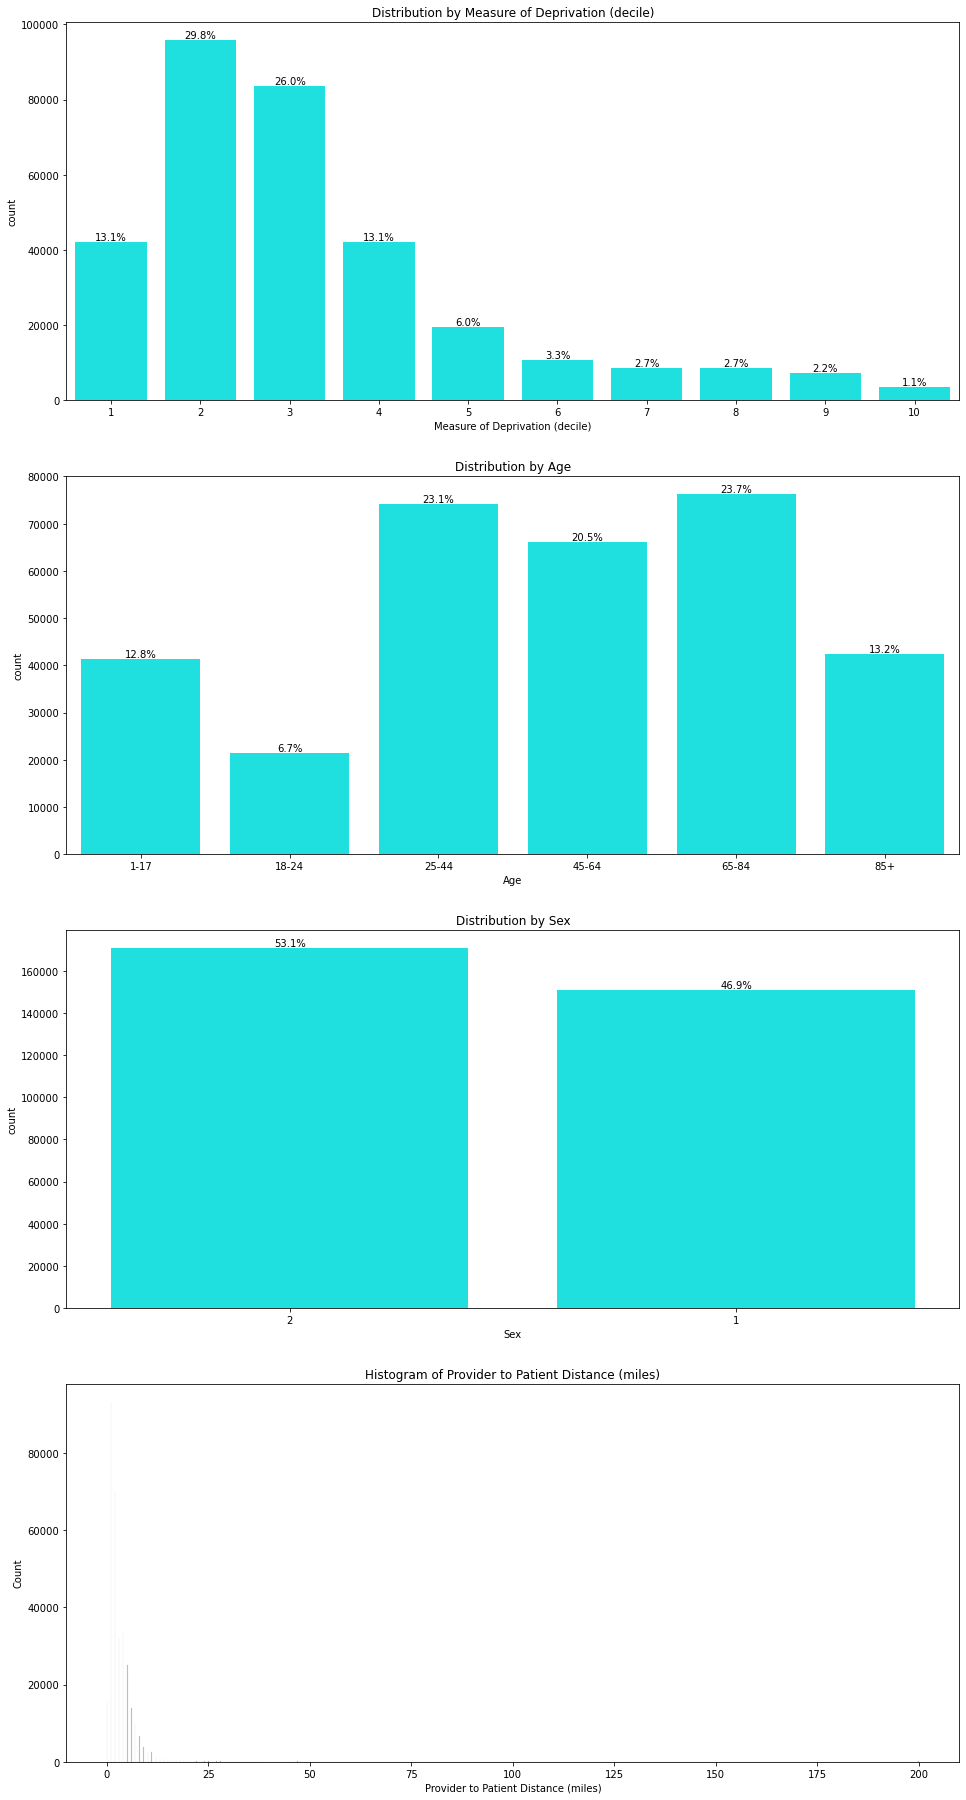

In [66]:
# Creating a graphs
univariate_multiplot(aedata_df,['IMD_Decile_From_LSOA','Age_Band','Sex', 'Provider_Patient_Distance_Miles'])

* It could be seen that majority of the A&E consults are patients that are coming from poorer areas
* Majority are adults from 25 to 84 years old
* There are more consults from the sex coded as 2, but their number is not that far from the other sex.
* There is a long tail in the distribution for provider to patient distance

/home/biogear13/miniconda3/envs/minimal_ds/lib/python3.10/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


([<matplotlib.axis.XTick at 0x7f2bec27e470>,
 [Text(0.0, 0, '0'),
  Text(0.5, 0, '3.16'),
  Text(1.0, 0, '10'),
  Text(1.5, 0, '31.63'),
  Text(2.0, 0, '100')])

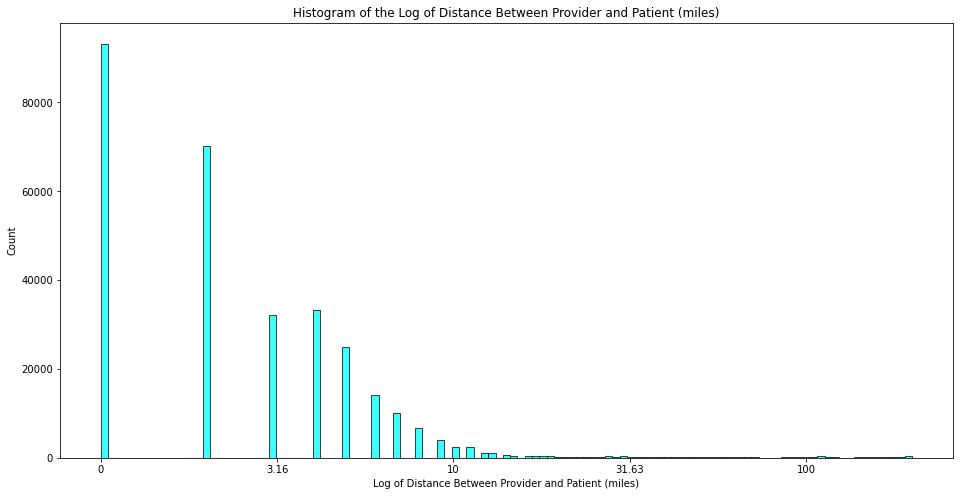

In [67]:
# There is a long tail in the distribution so I will look into the log scale
create_his_log(aedata_df, 'Provider_Patient_Distance_Miles', 'Log of Distance Between Provider and Patient (miles)')
# Change the xticks to be more understandable
plt.xticks([0,0.5,1.0,1.5,2.0], [0, 3.16, 10, 31.63, 100])

* It could be seen that the majority of patients are located less than 3 miles from the A&E care provider

### Temporal factors

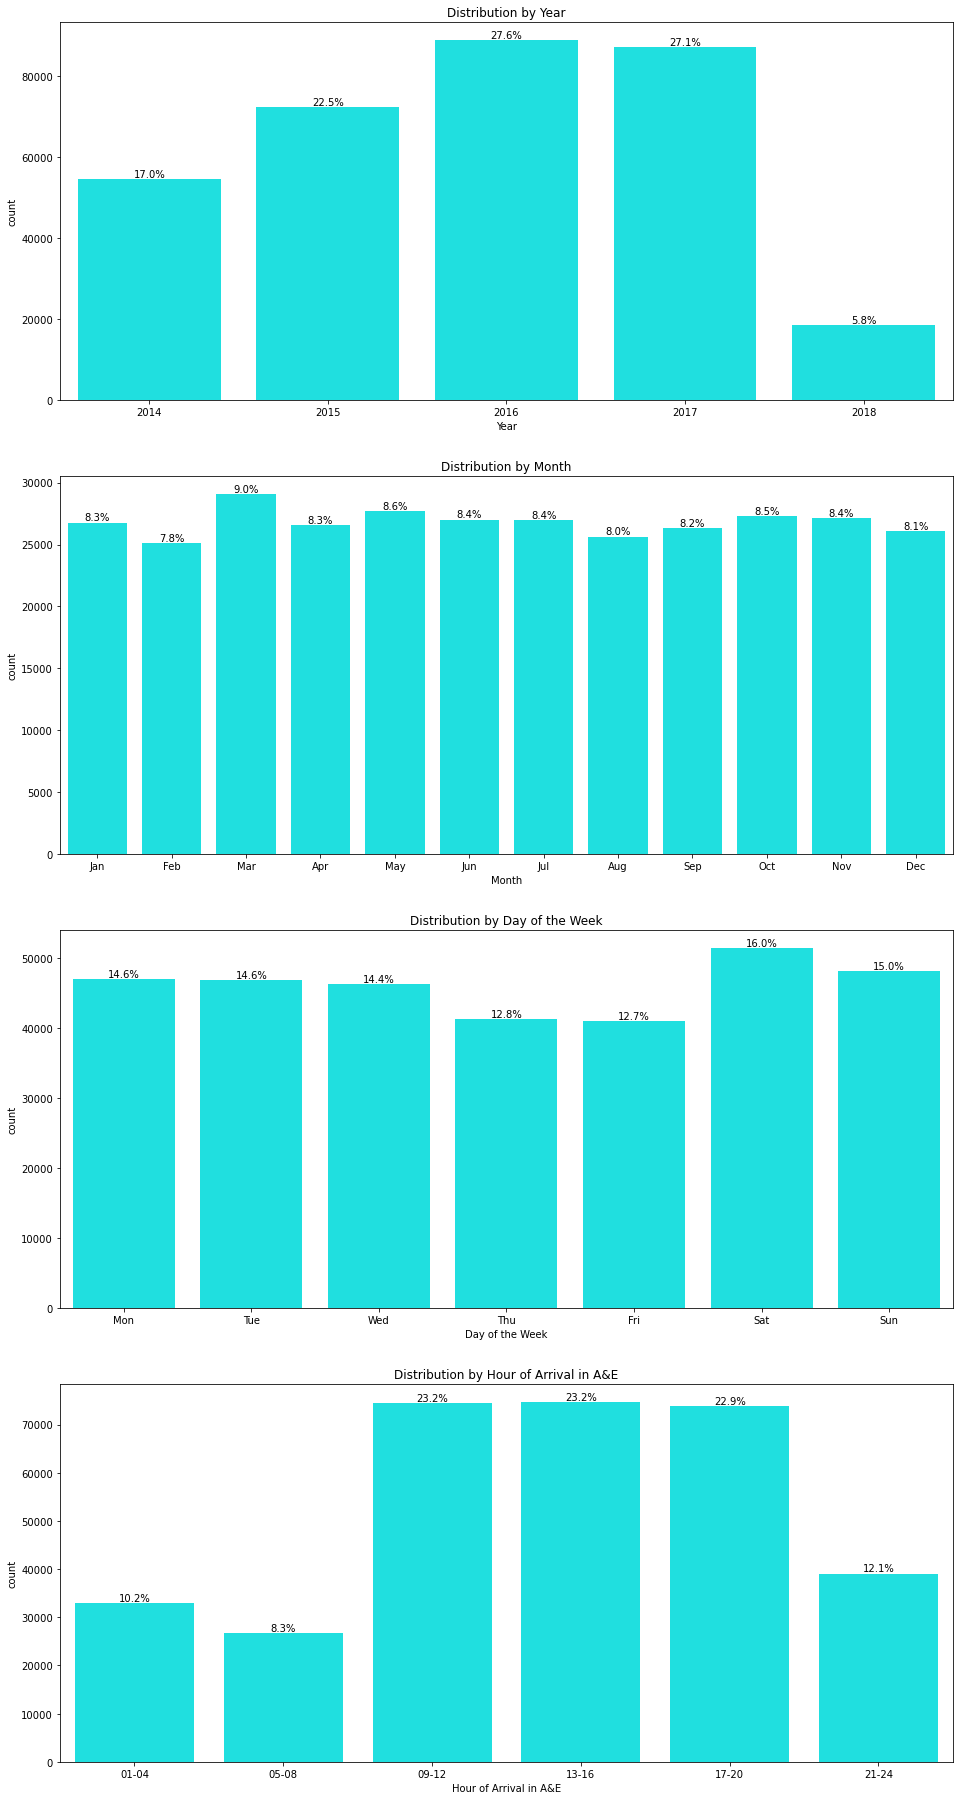

In [69]:
# Creating a graph
univariate_multiplot(aedata_df,['Year','Month','Weekday', 'AE_Arrive_HourOfDay'])

* Number of AE consults stabilized at year 2016 and 2017. It is important to note that our dataset does not contain the data for the entire year of 2014 and 2018
* By month the highest number of consult is during March adn the lowest is at February. It is also important to note that February has also the month with least amount of days
* Total count of admissions is the highest during the Saturdays and the Lowest at Fridays and Thursdays
* Highest number of admissions happens at 0900 to 2000 and lowest at 05-08.

Since the data is from March 2014 to March 2018 the difference in number of days by year and by month might skew the distribution so I proceeded to look at the distribution of the daily admission by time period.

In [70]:
# Dataframe for daily admissions
daily_admission=aedata_df.groupby(['AE_Arrive_Date']).apply(lambda x: pd.Series({
    'num_of_admissions':x['AE_Arrive_Date'].count(),
    'Year':x['Year'].unique()[0],
    'Month':x['Month'].unique()[0],
    'Weekday':x['Weekday'].unique()[0]
})).reset_index()

In [83]:
# Compute for the median daily admission by year
da_by_year=daily_admission.groupby(['Year']).apply(lambda x: pd.Series({
    'median':x['num_of_admissions'].median()
})).reset_index()

Text(0.5, 1.0, 'Barplot of the median number of daily admissions by Year')

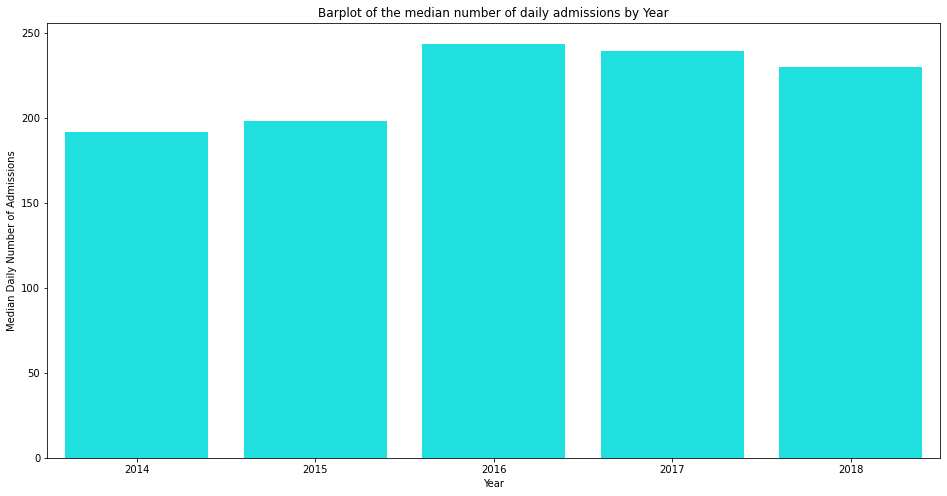

In [95]:
# Create a bar plot for the median daily admission
plt.figure(figsize=(16,8))
sns.barplot(data=da_by_year,x='Year',y='median', color='cyan',
order=['2014','2015','2016','2017','2018'])
plt.ylabel('Median Daily Number of Admissions')
plt.title('Barplot of the median number of daily admissions by Year')

* By looking at the daily admissions by year we could see a difference in the distribution by year. Now we could see that there is a spike in admissions from 2015 to 2016, compared in a gradual increase from 2014 to 2016 as we had seen earlier for the total admissions, then a slow decline but still above the 2015 values

In [92]:
# Compute for the median daily admission by month
da_by_month=daily_admission.groupby(['Month']).apply(lambda x: pd.Series({
    'median':x['num_of_admissions'].median()
})).reset_index()

Text(0.5, 1.0, 'Barplot of median number of daily admissions by Month')

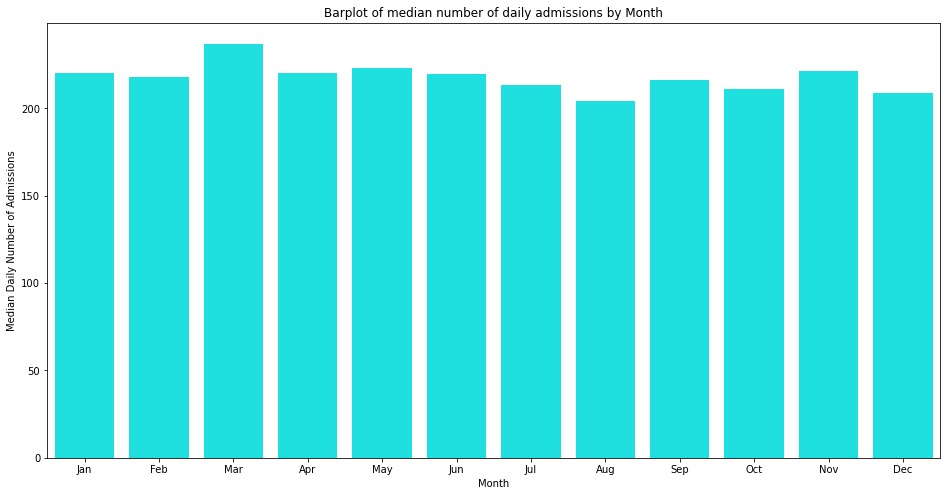

In [93]:
# Create a bar plot for the monthly daily admission
plt.figure(figsize=(16,8))
sns.barplot(data=da_by_month,x='Month',y='median', color='cyan',
order=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.ylabel('Median Daily Number of Admissions')
plt.title('Barplot of median number of daily admissions by Month')

* Looking at the daily admissions, median number of admissions is highest for March same month that also have the highest number of admissions but on the otherhand August is seen as the lowest in terms of median daily admission.

In [98]:
# Compute for the median daily admission by weekday
da_by_day=daily_admission.groupby(['Weekday']).apply(lambda x: pd.Series({
    'median':x['num_of_admissions'].median()
})).reset_index()

Text(0.5, 1.0, 'Boxplot of Median number of daily admissions by Day of the Week')

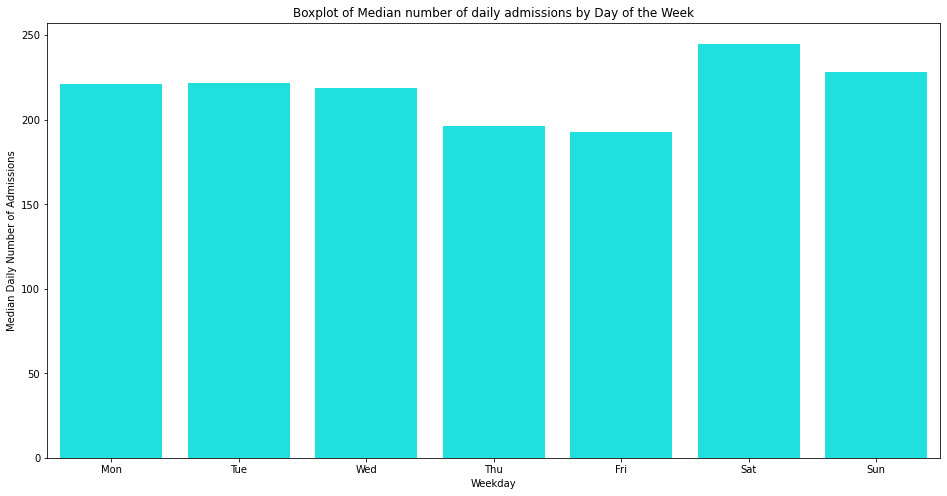

In [100]:
# Create a box plot for the daily admission by day
plt.figure(figsize=(16,8))
sns.barplot(data=da_by_day,x='Weekday',y='median', color='cyan',
order=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.ylabel('Median Daily Number of Admissions')
plt.title('Boxplot of Median number of daily admissions by Day of the Week')

In [74]:
# Dataframe for daily admissions by the hour of day
daily_admission_byhour=aedata_df.groupby(['AE_Arrive_Date','AE_Arrive_HourOfDay']).apply(lambda x: pd.Series({
    'num_of_admissions':x['AE_Arrive_Date'].count()
})).reset_index()

In [102]:
# Compute for the median daily admission by weekday
da_by_hour=daily_admission_byhour.groupby(['AE_Arrive_HourOfDay']).apply(lambda x: pd.Series({
    'median':x['num_of_admissions'].median()
})).reset_index()

Text(0.5, 1.0, 'Boxplot of median number of daily admissions by Hour of Day')

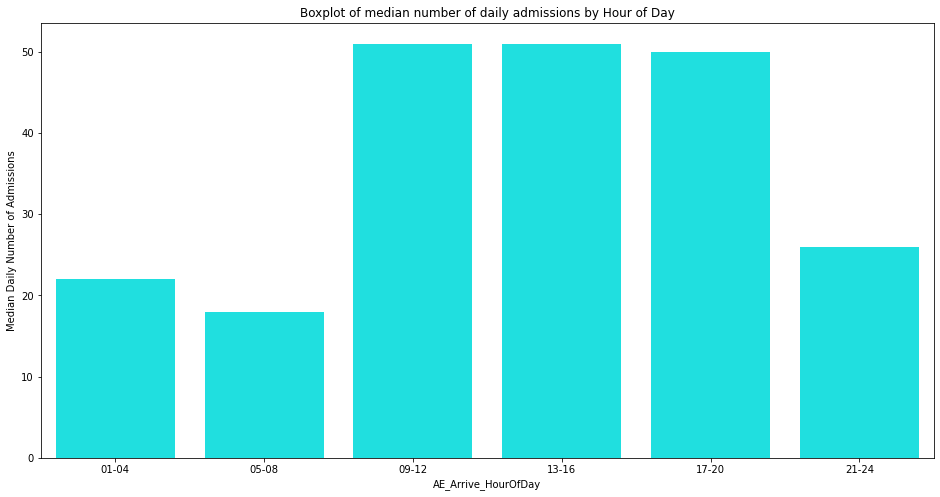

In [104]:
# Create a box plot for the monthly daily admission
plt.figure(figsize=(16,8))
sns.barplot(data=da_by_hour,x='AE_Arrive_HourOfDay',y='median', color='cyan',
order=['01-04','05-08','09-12','13-16','17-20','21-24'])
plt.ylabel('Median Daily Number of Admissions')
plt.title('Boxplot of median number of daily admissions by Hour of Day')

* For the median daily admission by weekday and by hourofday, we could see that the trend is similar that which was found with that of the total number of admission.

### Transfer Method

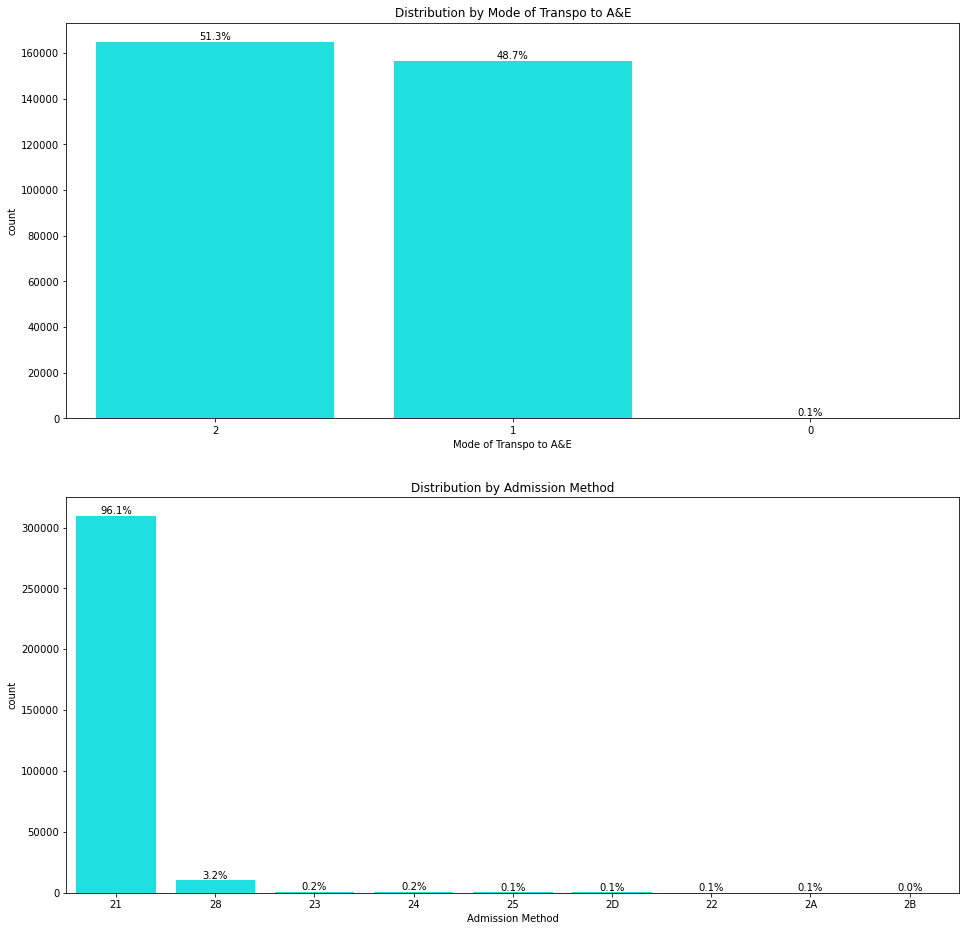

In [78]:
# Creating a graph
univariate_multiplot(aedata_df,['AE_Arrival_Mode','Admission_Method'])

* The arrival method [0] is almost negligeable and that all the others are almost equally distributed between arrival mode 1 and 2.
* Admission method 21 is the overwhelming majority and 28 is the next

### Disease and Treatment Factors

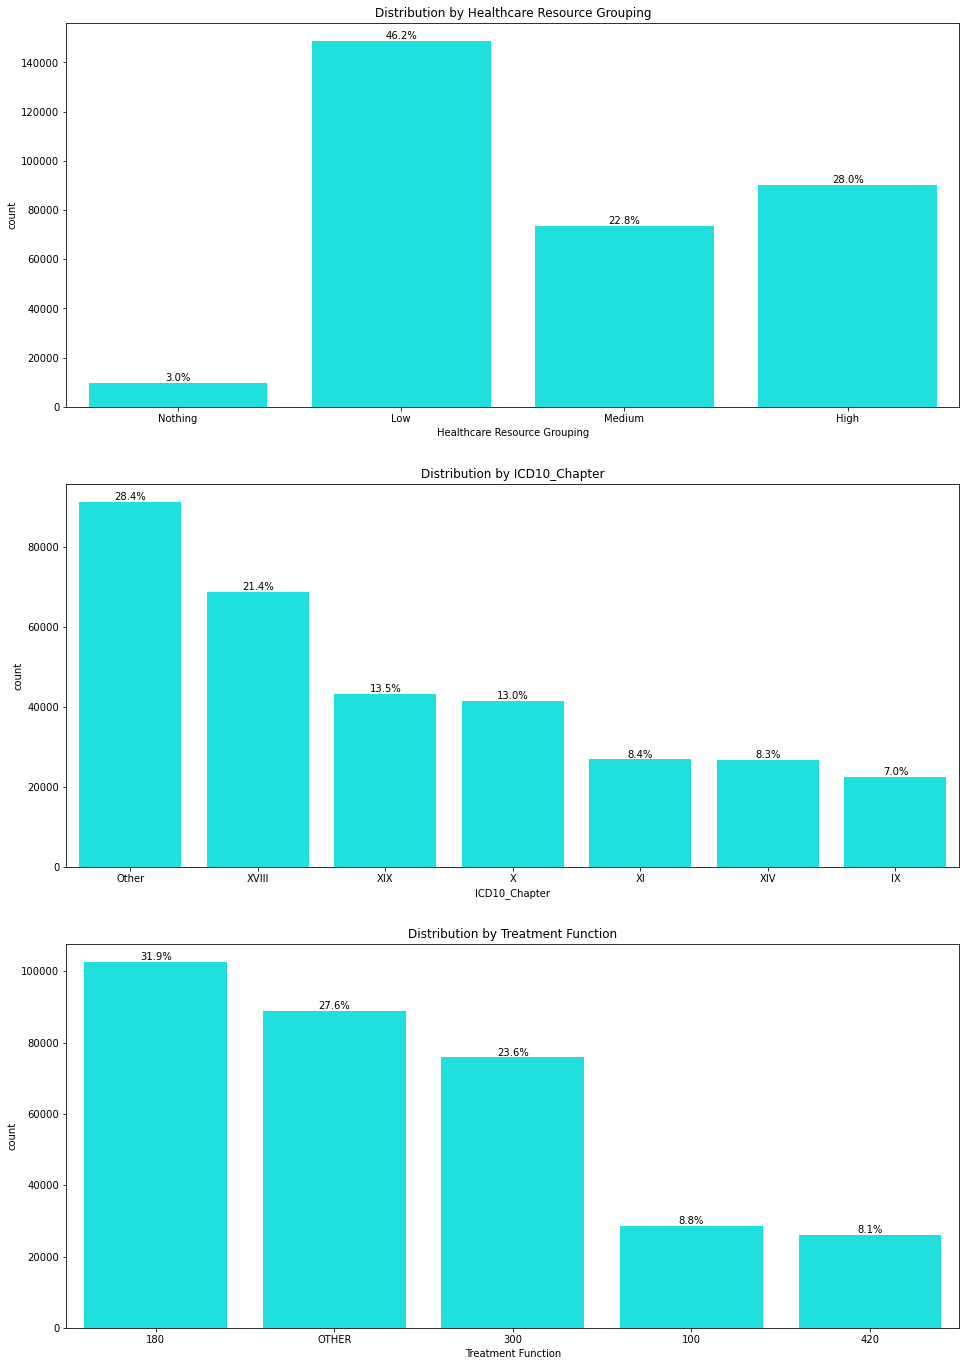

In [79]:
# Creating a graph
univariate_multiplot(aedata_df,['AE_HRG','ICD10_Chapter_Code','Treatment_Function_Code'])

* Almost half of the admissions needed low health care resource but more than a quarter needed high resource
* The highest at more than a quarter of admission is 'Others' meaning that the diagnosis does not fit to a specific ICD10 chapter
* The highest admission for 180 and more than a quarter are others.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> Your answer here!

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> Your answer here!

## Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your
data. Make sure the variables that you cover here have been introduced in some
fashion in the previous section (univariate exploration).

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> Your answer here!

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> Your answer here!

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Your answer here!

### Were there any interesting or surprising interactions between features?

> Your answer here!

## Conclusions
>You can write a summary of the main findings and reflect on the steps taken during the data exploration.



> Remove all Tips mentioned above, before you convert this notebook to PDF/HTML


> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML or PDF` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!

